In [1]:
import mne
import scipy
import numpy as np
import matplotlib.pyplot as plt
import utils
import algo
import copy
import os
import glob
from numpy import linalg as LA
from scipy.stats import zscore, pearsonr
from scipy.io import savemat, loadmat
from scipy import signal
%matplotlib widget

In [2]:
def clean_features(feats, smooth=True):
    y = copy.deepcopy(feats)
    # interpolate NaN values (linealy)
    T, nb_feature = y.shape
    for i in range(nb_feature):
        # interpolate NaN values
        nans, x= np.isnan(y[:,i]), lambda z: z.nonzero()[0]
        if any(nans):
            f1 = scipy.interpolate.interp1d(x(~nans), y[:,i][~nans], fill_value='extrapolate')
            y[:,i][nans] = f1(x(nans))
        if smooth:
            # extract envelope by finding peaks and interpolating peaks with spline
            idx_peaks = scipy.signal.find_peaks(y[:,i])[0]
            idx_rest = np.setdiff1d(np.array(range(T)), idx_peaks)
            # consider use quadratic instead
            f2 = scipy.interpolate.interp1d(idx_peaks, y[:,i][idx_peaks], kind='cubic', fill_value='extrapolate')
            y[:,i][idx_rest] = f2(idx_rest)
    return y

## Data loading

In [3]:
def multisub_data_org(subjects, video, folder='EOG', feature_type=['muFlow'], bads=[], band=None, eog=True, regression=True, normalize=True):
    feature_path = '../../Experiments/Videos/stimuli/' + video + '_features.mat'
    features_data = scipy.io.loadmat(feature_path)
    fsStim = int(features_data['fsVideo']) # fs of the video 
    features_list = [np.abs(np.nan_to_num(features_data[type])) for type in feature_type]
    features = np.concatenate(tuple(features_list), axis=1)
    # features = features/LA.norm(features) # Normalize here or normalize the concatenated features?
    T = features.shape[0]
    eeg_list = []
    for sub in subjects:
        eeg_path = '../../Experiments/data/'+ sub +'/' + folder + '/' + video + '.set'
        eeg_prepro, fs, _ = utils.preprocessing(eeg_path, HP_cutoff = 0.5, AC_freqs=50, band=band, resamp_freqs=fsStim, bads=bads, eog=eog, regression=regression, normalize=normalize)
        eeg_channel_indices = mne.pick_types(eeg_prepro.info, eeg=True)
        eeg_downsampled, _ = eeg_prepro[eeg_channel_indices]
        eeg_downsampled = eeg_downsampled.T
        eeg_list.append(eeg_downsampled)
        if eeg_downsampled.shape[0] < T:
            T = eeg_downsampled.shape[0]
    # Clip data
    features = features[:T, :]
    eeg_list = [np.expand_dims(eeg[:T,:], axis=2) for eeg in eeg_list]
    eeg_multisub = np.concatenate(tuple(eeg_list), axis=2)
    times = np.array(range(T))/fs
    return features, eeg_multisub, fs, times

In [4]:
%%capture
subjects = ['AS', 'YY']
folder = 'EOG'
# videos = ['Dr', 'Parra', 'Safety', 'Spring']
# videos = ['Parra', 'Dr']
videos = ['Dr', 'Safety', 'Spring']
feature_type = ['muFlow'] # muFlow, muTemporalContrast, muSqTemporalContrast
features_list = []
clean_features_list = []
handcrafted_list = []
eeg_multisub_list = []
clean_eeg_multisub_list = []
for video in videos:
    features, eeg_multisub, fs, _ = multisub_data_org(subjects, video, folder, feature_type=feature_type, bads=['B25'], band=None, eog=True, regression=True, normalize=True)
    features_list.append(clean_features(features)) # Or do a normalization here using zscore
    eeg_multisub_list.append(eeg_multisub)
    handcrafted = np.zeros_like(features)
    peaks = np.array([])
    for i in range(features.shape[1]):
        feature_normalized = features[:,i]/LA.norm(features[:,i])
        peak, _ = signal.find_peaks(np.squeeze(feature_normalized), prominence=(0.05, None), distance=fs, width=(None, 1.5))
        peaks = np.union1d(peaks, peak)
    peaks = peaks.astype(int)
    handcrafted[peaks, 0] = 1
    handcrafted_list.append(handcrafted)
    # nearby_idx = []
    # for p in peaks:
    #     nearby_idx = nearby_idx + list(range(max(0, p-int(fs/2)), min(p+int(fs/2), feature_normalized.shape[0])))
    # nearby_idx = list(set(nearby_idx))
    features = np.delete(features, peaks, axis=0)
    eeg_multisub = np.delete(eeg_multisub, peaks, axis=0)
    clean_features_list.append(clean_features(features))
    clean_eeg_multisub_list.append(eeg_multisub)

# feature_concat = np.concatenate(tuple(features_list), axis=0)
# feature_concat = feature_concat/LA.norm(feature_concat)
# clean_feature_concat = np.concatenate(tuple(clean_features_list), axis=0)
# clean_feature_concat = clean_feature_concat/LA.norm(clean_feature_concat)
# handcrafted_concat = np.concatenate(tuple(handcrafted_list), axis=0)
# eeg_multisub_concat = np.concatenate(tuple(eeg_multisub_list), axis=0)
# clean_eeg_multisub_concat = np.concatenate(tuple(clean_eeg_multisub_list), axis=0)
# T = feature_concat.shape[0]
# times = np.array(range(T))/fs

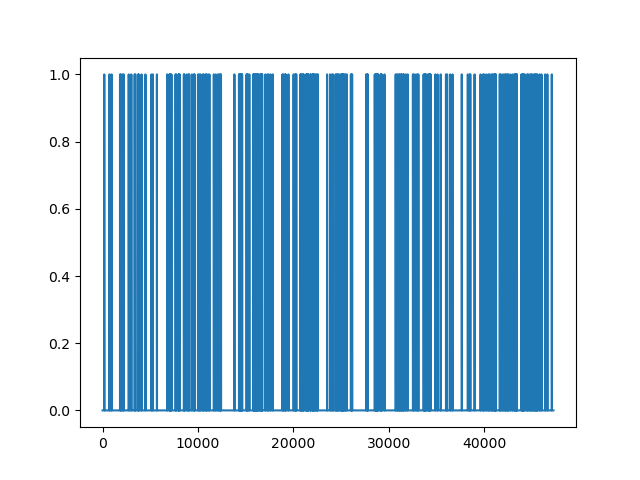

In [6]:
# peaks, _ = signal.find_peaks(np.squeeze(feature_concat), prominence=(0.05, None), width=(None, 1.5))
handcrafted_concat = np.concatenate(tuple(handcrafted_list), axis=0)
plt.close()
plt.plot(handcrafted_concat)
# plt.plot(feature_concat)
plt.show()

## CCA

In [10]:
id_sub = 1
eeg_onesub_list = [eeg[:,:,id_sub] for eeg in eeg_multisub_list]
eeg_onesub_clean_list = [eeg[:,:,id_sub] for eeg in clean_eeg_multisub_list]
Stim_list = features_list
Stim_clean_list = clean_features_list
L_EEG = 1 # correlations can be higher if include time lags
L_Stim = fs+1
CCA = algo.CanonicalCorrelationAnalysis(eeg_onesub_clean_list, Stim_clean_list, fs, L_EEG, L_Stim, offset_EEG=0, offset_Stim=int(fs/2))
corr_train, corr_test, dist_train, dist_test, V_A_train, V_B_train = CCA.cross_val()

100%|██████████| 1000/1000 [00:03<00:00, 260.03it/s]

Significance level: 0.029006932247767937
Average correlation coefficients of the top 5 components on the training sets: [0.10975651 0.10285863 0.08282267 0.07099769 0.0564392 ]
Average correlation coefficients of the top 5 components on the test sets: [-0.03336334  0.01361757  0.0163395   0.03805612  0.01167374]


In [12]:
id_sub = 0
eeg_onesub_list = [eeg[:,:,id_sub] for eeg in eeg_multisub_list]
eeg_onesub_clean_list = [eeg[:,:,id_sub] for eeg in clean_eeg_multisub_list]
Stim_list = features_list
Stim_clean_list = clean_features_list
L_EEG = 1 # correlations can be higher if include time lags
L_Stim = int(fs/2)
CCA = algo.CanonicalCorrelationAnalysis(eeg_onesub_clean_list, Stim_clean_list, fs, L_EEG, L_Stim, offset_EEG=0, offset_Stim=0)
corr_train, corr_test, dist_train, dist_test, V_A_train, V_B_train = CCA.cross_val()

100%|██████████| 1000/1000 [00:02<00:00, 340.30it/s]

Significance level: 0.028334781550483194
Average correlation coefficients of the top 5 components on the training sets: [0.11098472 0.1033202  0.06488806 0.04096027 0.03248044]
Average correlation coefficients of the top 5 components on the test sets: [ 0.01266688  0.06769987  0.0231359   0.00424695 -0.00230155]


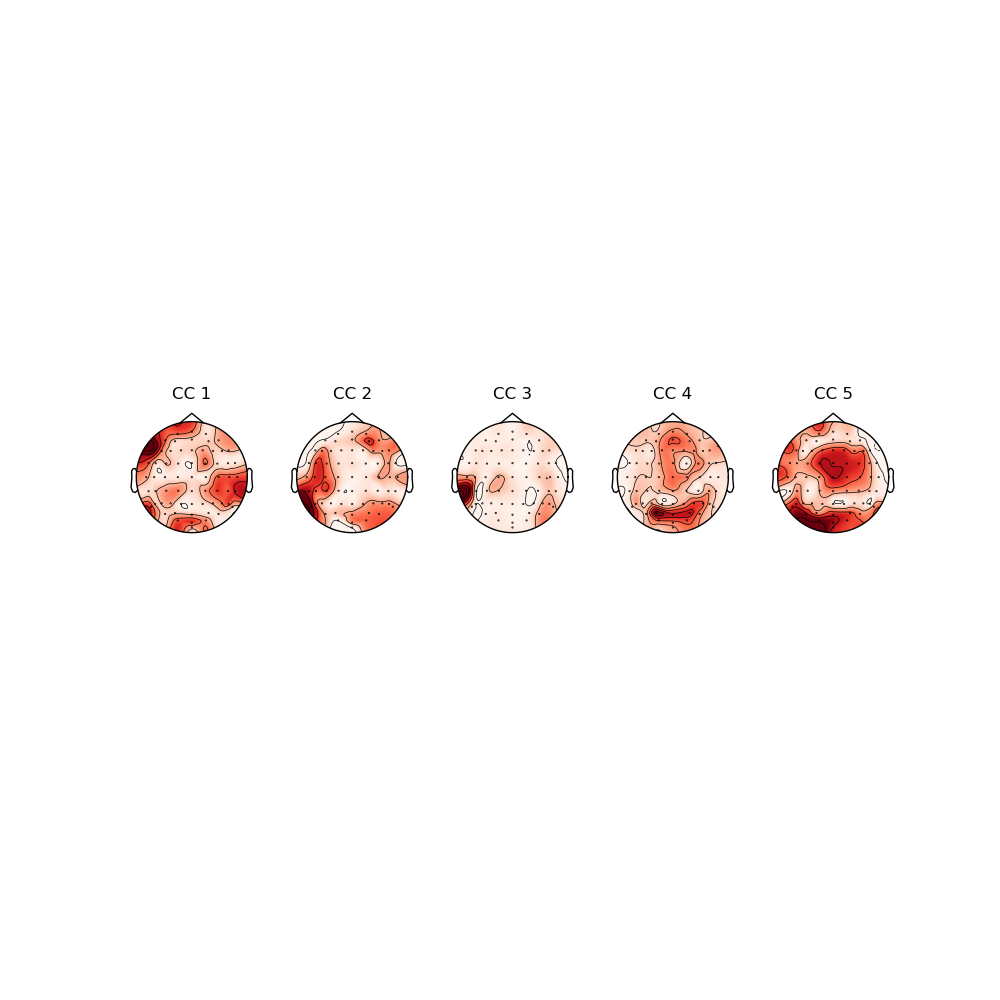

In [11]:
# Visualization: spatial (temporal) filter
eeg_onesub = np.concatenate(tuple(eeg_onesub_clean_list), axis=0)
forward_model = utils.forward_model(eeg_onesub, V_A_train, L_EEG, offset=1)
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure(figsize=(10, 10))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    mne.viz.plot_topomap(np.abs(forward_model[:,i]), create_info, ch_type='eeg', axes=ax, show=False)
    ax.set_title('CC '+str(i+1))
plt.show()
# plt.savefig('figures/CCA_'+str(id_sub)+'.png')

In [39]:
id_sub = 0
eeg_onesub_list = [eeg[:,:,id_sub] for eeg in eeg_multisub_list]
eeg_onesub_clean_list = [eeg[:,:,id_sub] for eeg in clean_eeg_multisub_list]
Stim_list = features_list
Stim_clean_list = clean_features_list
L_EEG = 1 # correlations can be higher if include time lags
L_Stim = int(fs/2)
CCA = algo.CanonicalCorrelationAnalysis(eeg_onesub_list, handcrafted_list, fs, L_EEG, L_Stim, offset_EEG=0, offset_Stim=0)
corr_train, corr_test, dist_train, dist_test, V_A_train, V_B_train = CCA.cross_val()

100%|██████████| 1000/1000 [00:03<00:00, 250.52it/s]

Significance level: 0.027471372497135847
Average correlation coefficients of the top 5 components on the training sets: [0.224753   0.11940024 0.0682586  0.04412286 0.03942428]
Average correlation coefficients of the top 5 components on the test sets: [0.19537985 0.08283313 0.03728924 0.01371474 0.01747622]


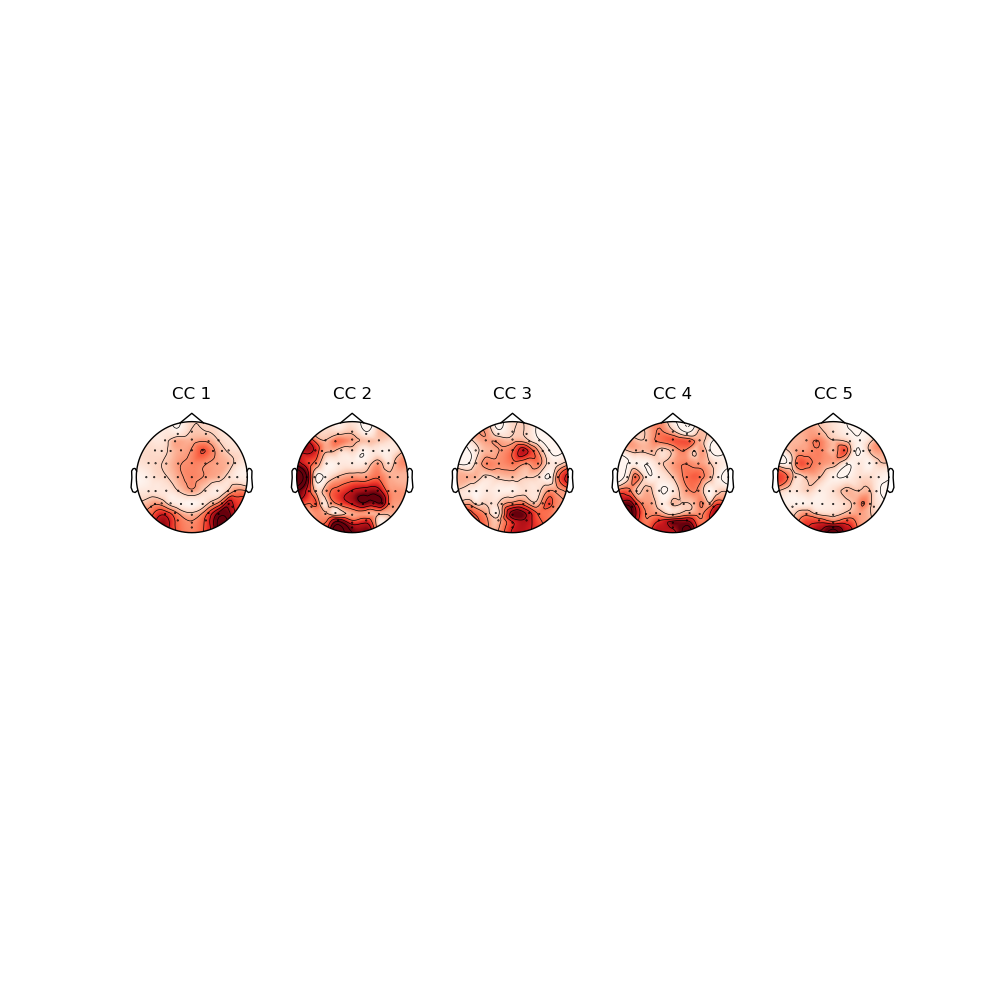

In [40]:
# Visualization: spatial (temporal) filter
eeg_onesub = np.concatenate(tuple(eeg_onesub_clean_list), axis=0)
forward_model = utils.forward_model(eeg_onesub, V_A_train, L_EEG, offset=1)
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure(figsize=(10, 10))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    mne.viz.plot_topomap(np.abs(forward_model[:,i]), create_info, ch_type='eeg', axes=ax, show=False)
    ax.set_title('CC '+str(i+1))
plt.show()
# plt.savefig('figures/CCA_'+str(id_sub)+'.png')

In [ ]:
# Visualization: spatial (temporal) filter
eeg_onesub = np.concatenate(tuple(eeg_onesub_clean_list), axis=0)
forward_model = utils.forward_model(eeg_onesub, V_A_train, L_EEG, offset=1)
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure(figsize=(10, 10))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    mne.viz.plot_topomap(np.abs(forward_model[:,i]), create_info, ch_type='eeg', axes=ax, show=False)
    ax.set_title('CC '+str(i+1))
plt.show()
# plt.savefig('figures/CCA_'+str(id_sub)+'.png')

In [24]:
L_timefilter = int(fs)
n_components = 5
fold = 10
eeg_onesub = eeg_multisub_concat[:,:,1]
corr_train, corr_test, V_A_train, V_B_train = utils.cross_val_CCA(eeg_onesub, handcrafted_concat, fs, L_EEG=1, L_feat=fs+1, causalx=False, causaly=False, fold=10, n_components=5, regularization='lwcov', K_regu=None, message=True, signifi_level=True)


100%|██████████| 1000/1000 [00:06<00:00, 154.47it/s]

Significance level: 0.027069018057125346
Average correlation coefficients of the top 5 components on the training sets: [0.22341859 0.16177365 0.11041264 0.08679144 0.06541926]
Average correlation coefficients of the top 5 components on the test sets: [0.19379994 0.1327942  0.08806975 0.00425394 0.00574024]


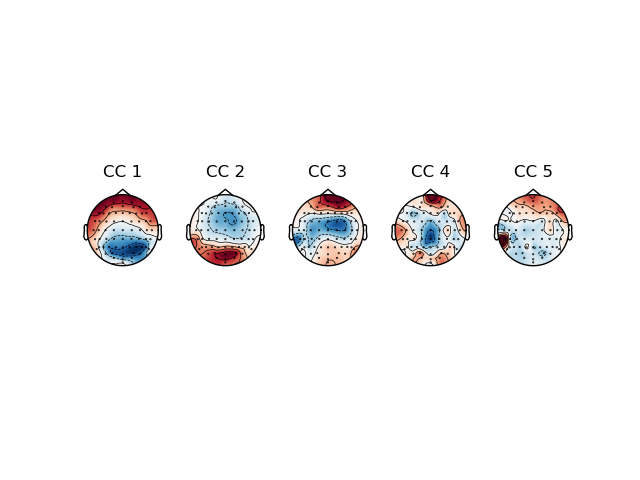

In [25]:
# Visualization:
forward_model = utils.forward_model(eeg_onesub, V_A_train)
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure()
# plt.figure(figsize=(20, 20))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    mne.viz.plot_topomap(forward_model[:,i], create_info, ch_type='eeg', axes=ax, show=False)
    ax.set_title('CC '+str(i+1))
plt.show()

In [26]:
L_timefilter = int(fs)
n_components = 5
fold = 10
eeg_onesub = clean_eeg_multisub_concat[:,:,0]
corr_train, corr_test, V_A_train, V_B_train = utils.cross_val_CCA(eeg_onesub, clean_feature_concat, fs, L_EEG=1, L_feat=fs+1, causalx=False, causaly=False, fold=10, n_components=5, regularization='lwcov', K_regu=None, message=True, signifi_level=True)


100%|██████████| 1000/1000 [00:06<00:00, 150.02it/s]

Significance level: 0.02607570622775382
Average correlation coefficients of the top 5 components on the training sets: [0.12813517 0.09612221 0.07276256 0.06024977 0.05339133]
Average correlation coefficients of the top 5 components on the test sets: [ 0.04609934  0.03553528  0.02210494 -0.00400449  0.02157829]


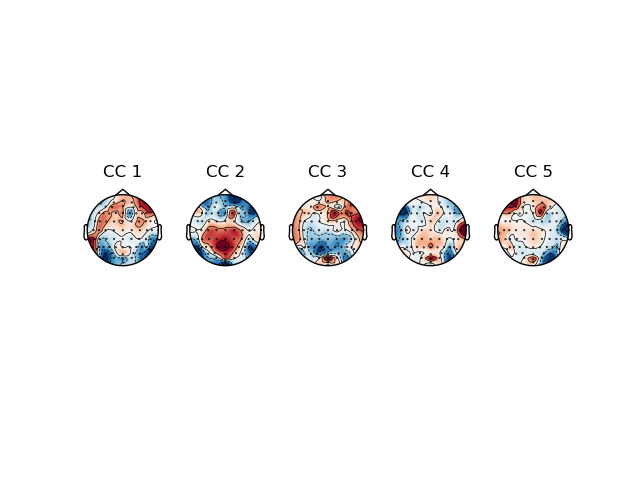

In [27]:
# Visualization:
forward_model = utils.forward_model(eeg_onesub, V_A_train)
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure()
# plt.figure(figsize=(20, 20))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    mne.viz.plot_topomap(forward_model[:,i], create_info, ch_type='eeg', axes=ax, show=False)
    ax.set_title('CC '+str(i+1))
plt.show()

In [28]:
L_timefilter = int(fs)
n_components = 5
fold = 10
eeg_onesub = clean_eeg_multisub_concat[:,:,1]
corr_train, corr_test, V_A_train, V_B_train = utils.cross_val_CCA(eeg_onesub, clean_feature_concat, fs, L_EEG=1, L_feat=fs+1, causalx=False, causaly=False, fold=10, n_components=5, regularization='lwcov', K_regu=None, message=True, signifi_level=True)


100%|██████████| 1000/1000 [00:05<00:00, 175.62it/s]

Significance level: 0.02672986867086624
Average correlation coefficients of the top 5 components on the training sets: [0.10989696 0.09824207 0.07680709 0.0622303  0.05786313]
Average correlation coefficients of the top 5 components on the test sets: [-0.00360565  0.0180081   0.01019011  0.00714978  0.02943252]


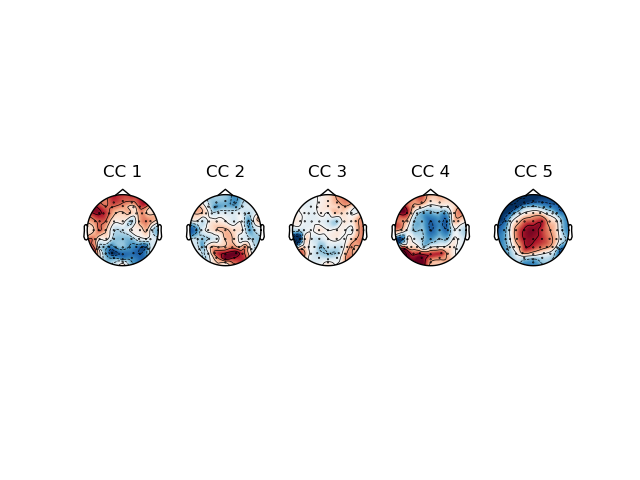

In [30]:
# Visualization:
forward_model = utils.forward_model(eeg_onesub, V_A_train)
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure()
# plt.figure(figsize=(20, 20))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    mne.viz.plot_topomap(forward_model[:,i], create_info, ch_type='eeg', axes=ax, show=False)
    ax.set_title('CC '+str(i+1))
plt.show()

In [ ]:
# Note: GCCA-one subject + stimulus = CCA
datalist = [eeg_multisub_concat[:,:,0], feature_concat]
Llist = [1, fs]
causal_list = [False, True]
n_components = 5
rhos= [1, 1]
corr_train, corr_test, Wlist_train, Flist_train = utils.cross_val_GCCA_multi_mod(datalist, Llist, causal_list, rhos, fs, fold=10, n_components=5, regularization='lwcov', message=True, signifi_level=True, ISC=True)

In [ ]:
# GCCA-all subjects
datalist = [eeg_multisub_concat]
Llist = [1]
causal_list = [False]
n_components = 5
rhos = [1]
corr_train, corr_test, Wlist_train, Flist_train = utils.cross_val_GCCA_multi_mod(datalist, Llist, causal_list, rhos, fs, fold=10, n_components=5, regularization='lwcov', message=True, signifi_level=True, ISC=True)

In [ ]:
# GCCA-all subjects + stimulus
datalist = [eeg_multisub_concat, feature_concat]
Llist = [1, fs]
causal_list = [False, True]
n_components = 5
rhos = utils.rho_sweep(datalist, np.linspace(-2,3,11), Llist, causal_list, fs, fold=10, n_components=5, message=True)
corr_train, corr_test, Wlist_train, Flist_train = utils.cross_val_GCCA_multi_mod(datalist, Llist, causal_list, rhos, fs, fold=10, n_components=5, regularization='lwcov', message=True, signifi_level=True, ISC=True)

In [ ]:
# Forward_model: calculated using the shared subspace of all subjects/views
# forward_model = Flist_train[0][:,0,:] # subject 1
# Average forward model of different subjects
nb_sub = Flist_train[0].shape[1]
forward_model = np.zeros_like(Flist_train[0][:,0,:])
for n in range(nb_sub):
    forward_model = forward_model + Flist_train[0][:,n,:]
forward_model = forward_model/nb_sub
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure()
# plt.figure(figsize=(20, 20))
for i in range(5):
    ax = plt.subplot(2, 3, i + 1)
    mne.viz.plot_topomap(forward_model[:,i], create_info, ch_type='eeg', axes=ax)
    ax.set_title('CC '+str(i+1))
plt.show()

In [ ]:
# Forward_model: calculated using projected subspaces of each subject
forward_model = utils.forward_model(eeg_multisub_concat[:,:,0], Wlist_train[0][:,0,:], regularization=None) # subject 1
# forward_model = utils.forward_model(eeg_multisub_concat[:,:,1], Wlist_train[0][:,1,:], regularization=None) # subject 2
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure()
# plt.figure(figsize=(20, 20))
for i in range(5):
    ax = plt.subplot(2, 3, i + 1)
    mne.viz.plot_topomap(forward_model[:,i], create_info, ch_type='eeg', axes=ax)
    ax.set_title('CC '+str(i+1))
plt.show()

## Find appropriate amount of time

Old version. Do not run.

In [ ]:
L_timefilter = int(fs)
n_components = 5
fold = 10
t_list = range(1, 30)
corr_test_t = np.empty((0, n_components))
for t in t_list:
    eeg = eeg_multisub_concat[:t*fs*60, :, 0]
    feature = feature_concat[:t*fs*60, :]
    corr_train, corr_test, V_A_train, V_B_train = utils.cross_val_CCA(eeg, feature, fs, L_EEG=1, L_feat=fs, causalx=False, causaly=True, fold=10, n_components=5, regularization='lwcov', K_regu=None, message=True, signifi_level=True)
    corr_test_t = np.append(corr_test_t, np.mean(corr_test, axis=0, keepdims=True), axis=0)


In [ ]:
plt.close()
plt.plot(t_list, corr_test_t[:,0], label='1st component')
plt.plot(t_list, corr_test_t[:,1], label='2nd component')
plt.axhline(y=0.0431, linestyle='-.', color='c', label='significance level')
plt.legend(loc='best')
plt.xlabel('data length (min)')
plt.title('Average correlation coefficient on the test sets (CCA)')
plt.show()

In [ ]:
L_timefilter = int(fs)
n_components = 5
fold = 10
sweep_list = np.linspace(-1,3,9) # 10^{-2}, 10^{-2.5}, ..., 10^{3}
t_list = range(1, 30)
corr_test_t = np.empty((0, n_components))
for t in t_list:
    eeg = eeg_multisub_concat[:t*fs*60, :, :]
    feature = feature_concat[:t*fs*60, :]
    rhos = utils.rho_sweep([eeg, feature], sweep_list, L_timefilter, fold, n_components)
    corr_train, corr_test, Wlist = utils.cross_val_GCCA_multi_mod([eeg, feature], L_timefilter, rhos, fold, n_components, regularizaion='lwcov', message=False)
    print('ISC of the top {} components on the test sets when rhos={}: {}'.format(n_components, rhos, np.average(corr_test, axis=0)))
    corr_test_t = np.append(corr_test_t, np.mean(corr_test, axis=0, keepdims=True), axis=0)

In [ ]:
plt.close()
plt.plot(t_list, corr_test_t[:,0], label='1st component')
plt.plot(t_list, corr_test_t[:,1], label='2nd component')
plt.plot(t_list, corr_test_t[:,2], label='3rd component')
plt.axhline(y=0.0191, linestyle='-.', color='c', label='significance level')
plt.legend(loc='best')
plt.xlabel('data length (min)')
plt.title('Average correlation coefficient on the test sets (GCCA)')
plt.show()